In [340]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from shapely.geometry import Polygon

In [341]:
# 加载停车场数据
data = pd.read_csv("../data/lots_1687.csv")
print(data.head())

  LotID Agency Area                             Development LotType  OBJECTID  \
0   A10    HDB  NaN        BLK 201/202 ANG MO KIO STREET 22       C   96662.0   
1  A100    HDB  NaN            BLK 650 ANG MO KIO STREET 61       C   89869.0   
2   A11    HDB  NaN  BLK 223/226/226A-226D ANG MO KIO ST 22       C  108839.0   
3   A12    HDB  NaN            BLK 229/230 ANG MO KIO ST 22       C  108768.0   
4   A13    HDB  NaN            BLK 232/233 ANG MO KIO ST 22       C  108768.0   

       LU_DESC LU_TEXT                   LU_DT_DESC  GPR  ...  \
0  RESIDENTIAL          PUBLIC HOUSING - NON-LANDED  2.8  ...   
1  RESIDENTIAL          PUBLIC HOUSING - NON-LANDED  3.5  ...   
2  RESIDENTIAL                                  NaN  2.8  ...   
3  RESIDENTIAL                                  NaN  2.8  ...   
4  RESIDENTIAL                                  NaN  2.8  ...   

             SYSTEM_ID  SHAPE_Length     SHAPE_Area      n_lots  Latitude  \
0        180718-105080    983.107508   22261.

In [342]:
print("=================================================")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   LotID                            1687 non-null   object 
 1   Agency                           1687 non-null   object 
 2   Area                             34 non-null     object 
 3   Development                      1687 non-null   object 
 4   LotType                          1687 non-null   object 
 5   OBJECTID                         1687 non-null   float64
 6   LU_DESC                          1687 non-null   object 
 7   LU_TEXT                          996 non-null    object 
 8   LU_DT_DESC                       1295 non-null   object 
 9   GPR                              1668 non-null   object 
 10  GPR_NUM                          1489 non-null   float64
 11  WHI_Q_MX                         0 non-null      float64
 12  GPR_B_MN            

In [343]:
print(data.describe())

            OBJECTID      GPR_NUM  WHI_Q_MX  GPR_B_MN   SUBZONE_NO  \
count    1687.000000  1489.000000       0.0       0.0  1687.000000   
mean    62013.188500     2.937139       NaN       NaN     4.311796   
std     35518.782395     0.489291       NaN       NaN     2.784894   
min      1273.000000     1.000000       NaN       NaN     1.000000   
25%     26954.000000     2.800000       NaN       NaN     2.000000   
50%     76942.000000     2.800000       NaN       NaN     4.000000   
75%     89090.000000     3.000000       NaN       NaN     6.000000   
max    127333.000000     8.400000       NaN       NaN    16.000000   

          CREATE_DT    LST_MDF_DT  SHAPE_Length     SHAPE_Area       n_lots  \
count  1.687000e+03  1.687000e+03   1687.000000    1687.000000  1687.000000   
mean   1.234844e+12  1.575708e+12   1470.397516   63925.474868   335.211124   
std    1.249668e+11  1.917474e+10    973.196716   46350.534537   301.117965   
min   -2.209162e+12  1.393429e+12     74.826361     3

In [344]:
# 创建基本地图
# 使用所有点的平均位置作为中心，或者选择一个具体的坐标
average_latitude = data['Latitude'].mean()
average_longitude = data['Longitude'].mean()
m = folium.Map(location=[average_latitude, average_longitude], zoom_start=12,
               tiles='CartoDB positron', attr='CartoDB.Positron')
m_ori = folium.Map(location=[average_latitude, average_longitude],
                        zoom_start=12,
                        tiles='OpenStreetMap',attr='Stamen')
m_ori.save('map_without_nodes.html')


In [345]:
# 颜色编码函数，根据停车位数量返回对应的颜色
def get_color(available):
    if available > 500:
        return '#FFAAAA'  # 淡红色
    elif 300 <= available < 500:
        return '#FFD700'  # 金色
    elif 100 <= available < 300:
        return '#FFFFAA'  # 淡黄色
    else:
        return '#AAFFAA'  # 淡绿色
    
def get_dark_color(available):
    if available > 500:
        return '#E60012'  # 深红色
    elif 300 <= available < 500:
        return '#FF8C00'  # 橙色
    elif 100 <= available < 300:
        return '#FFA500'  # 较深的黄色
    else:
        return '#008000'  # 深绿色

In [346]:
# 添加标记
for index, row in data.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    color = get_color(row['n_lots'])
    dark_color = get_dark_color(row['n_lots'])
    folium.CircleMarker(
        location=[lat, lon],
        radius=10,  # row['n_lots'] / 50,
        color= dark_color, #color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        stroke=True,  # 开启描边
        stroke_color='#000000',  # 描边颜色为黑色
        stroke_width=1,  # 描边宽度
        popup=f"Lot ID: {row['LotID']}<br>Available: {row['n_lots']}"
    ).add_to(m)


In [347]:
# 图例
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 250px; height: 200px; 
     border:2px solid grey; z-index:9999; font-size:16px;
     background-color: white; opacity: 0.8;">
     &nbsp; <strong>Parking Availability</strong><br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:#E60012"></i> &nbsp; 0 - 100<br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:#FF8C00"></i> &nbsp; 100 - 300<br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:#FFA500"></i> &nbsp; 300 - 500<br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:#008000"></i> &nbsp; > 500
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

In [348]:
# 模拟时序数据
time_series_data = {
    "LotID": "L1",
    "TimeSeries": [
        {"Time": "08:00", "Available": 450},
        {"Time": "12:00", "Available": 300},
        {"Time": "16:00", "Available": 200}
    ]
}

# 获取第一个停车场的数据
first_lot = time_series_data["TimeSeries"]

In [349]:
# 创建时序图
time_series_chart = """
<div id="chart_div" style="width: 300px; height: 200px;"></div>
<script type="text/javascript" src="https://www.gstatic.com/charts/loader.js"></script>
<script type="text/javascript">
google.charts.load('current', {'packages':['corechart']});
google.charts.setOnLoadCallback(drawChart);

function drawChart() {
    var data = new google.visualization.DataTable();
    data.addColumn('string', 'Time');
    data.addColumn('number', 'Available Slots');

    data.addRows([
"""

for entry in first_lot:
    time_series_chart += f"        ['{entry['Time']}', {entry['Available']}],\n"

time_series_chart += """
    ]);

    var options = {
        title: 'Parking Availability Over Time',
        hAxis: {title: 'Time'},
        vAxis: {title: 'Available Slots'},
        legend: 'none'
    };

    var chart = new google.visualization.LineChart(document.getElementById('chart_div'));
    chart.draw(data, options);
}
</script>
"""

# 将时序图添加到地图
folium.Html(time_series_chart, script=True).add_to(m)


In [350]:

# 保存地图为HTML文件
m.save('map_fixed_plots_10.html')


In [351]:
def set_style(ax):
    # 添加坐标轴样式
    ax.set_yticks([])  # 隐藏y轴刻度
    ax.set_xticks([])  # 隐藏x轴刻度
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')

    # 加粗坐标轴
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # 调整此处的值来改变坐标轴的粗细

    ax.patch.set_alpha(0.8)  # 轴背景半透明

    return ax

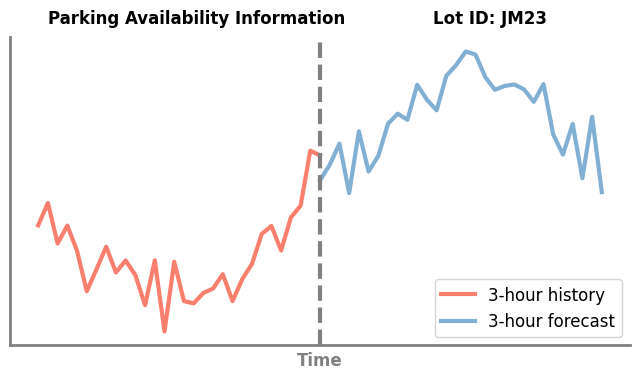

In [352]:
import matplotlib.pyplot as plt
import numpy as np

# 创建数据
time_history = np.linspace(-3, 0,30)  # 3小时历史时间
time_forecast = np.linspace(0, 3, 30)  # 3小时预测时间

history_data = np.sin(time_history) + np.random.normal(0, 0.2, len(time_history))  # 随机历史数据
forecast_data = np.sin(time_forecast) + np.random.normal(0, 0.2, len(time_forecast))  # 随机预测数据

# 创建图形
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_history, history_data, color='#FA7F6F', label='3-hour history',linewidth=3)  # 历史数据
ax.plot(time_forecast, forecast_data, color='#82B0D2', label='3-hour forecast',linewidth=3)  # 预测数据

# 添加垂直分界线
ax.axvline(0, color='gray', linestyle='--', linewidth=3)

# 添加标题和标签
ax.text(-2.9, 1.5, 'Parking Availability Information', fontsize=12, fontweight='bold', color='black', ha='left')
ax.text(1.2, 1.5, 'Lot ID: JM23', fontsize=12, fontweight='bold', color='black', ha='left')

# 标注历史和预测
#ax.text(-1.5, -1.2, '3-hour history', color='red', fontsize=12, ha='center',)
#ax.text(1.5, -1.2, '3-hour forecast', color='green', fontsize=12, ha='center')

# 添加坐标轴样式
ax.set_xlabel('Time', fontsize=12, fontweight='bold', color='gray')
ax = set_style(ax)

# 背景设置为透明（类似PPT风格）
fig.patch.set_alpha(0.0)  # 整个图形透明

# 显示图例
ax.legend(loc='lower right', fontsize=12)

# 显示图形
plt.show()

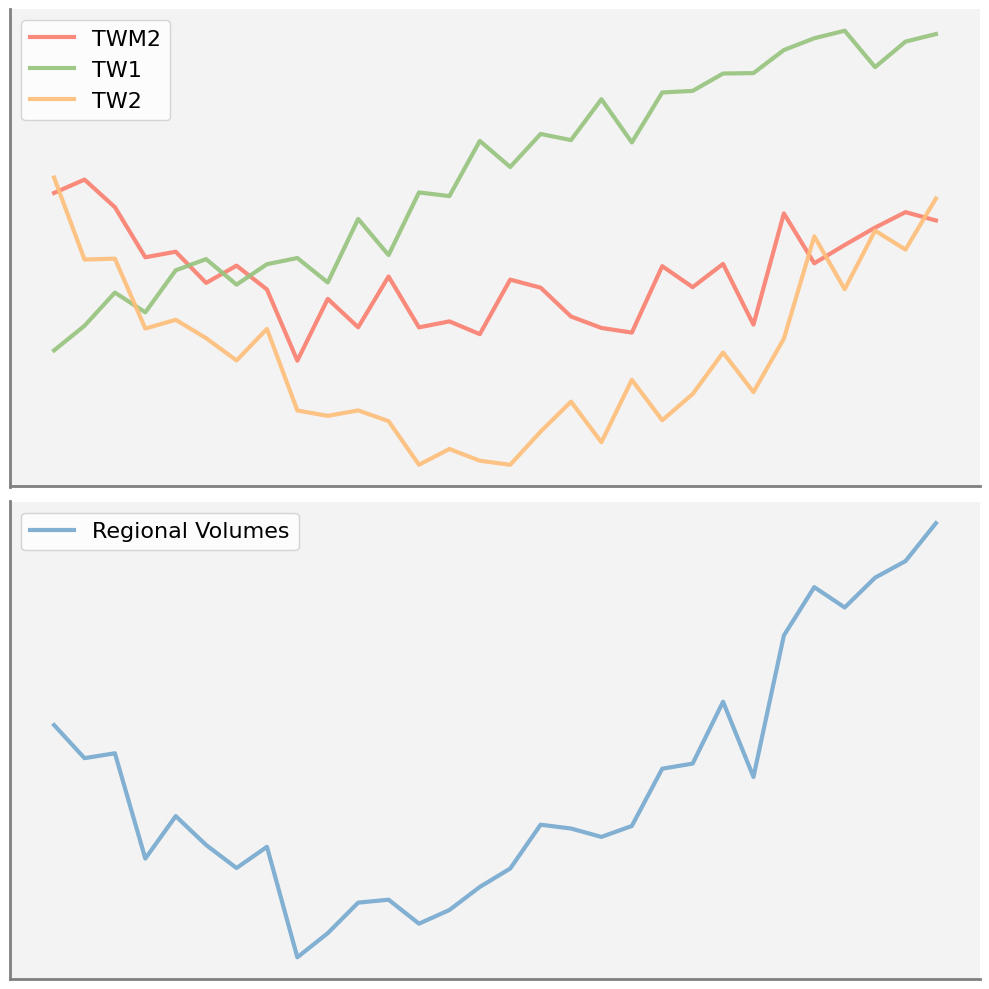

In [357]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

# 生成示例数据
np.random.seed(998244353)
data_A = np.sin(time_history) + np.random.normal(0, 0.2, len(time_history))  # 随机历史数据
data_B = np.cos(time_history) + np.random.normal(0, 0.2, len(time_history))  # 随机历史数据
data_C = np.sin(time_history) + np.sin(time_history) + np.random.normal(0, 0.2, len(time_history))  # 随机历史数据
merged_data = data_A + data_B + data_C # + np.random.normal(0, 0.1, len(time_history))

# 创建时序图
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# 第一行：三个区域的停车量时序数据
axs[0] = set_style(axs[0])
axs[0].plot(data_A, label='TWM2', color='#FA7F6F',linewidth=3,alpha=0.9)
axs[0].plot(data_B, label='TW1', color='#96C37D',linewidth=3,alpha=0.9)
axs[0].plot(data_C, label='TW2', color='#FFBE7A',linewidth=3,alpha=0.9)
#axs[0].set_title('Normalized Volumes of A, B and C during the same periods',fontsize=12)
#axs[0].set_xlabel('Time Steps',fontsize=12)
#axs[0].set_ylabel('Normalized Volumes',fontsize=12)
axs[0].legend(fontsize=16)

# 第二行：整个区域的聚合估计的时序数据
axs[1] = set_style(axs[1])
axs[1].plot(merged_data, label='Regional Volumes', color='#82B0D2', linewidth=3)
#axs[1].set_title('Regional Volumes',fontsize=12)
#axs[1].set_xlabel('Time Steps',fontsize=12)
#axs[1].set_ylabel('Regional Volumes',fontsize=12)
axs[1].legend(fontsize=16,loc='upper left')

# 背景设置为透明（类似PPT风格）
fig.patch.set_alpha(0.0)  # 整个图形透明

fig.patch.set_facecolor('#f0f0f0')  # 浅灰色背景
for ax in axs:
    ax.set_facecolor('#f0f0f0')  # 每个子图背景也为浅灰色
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='#cccccc')  # 添加网格

plt.tight_layout()
plt.show()